In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
from matplotlib import pyplot as plt
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU
import random
from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16


In [2]:
image_path="/kaggle/input/watersegmentation2/data/images"
label_path="/kaggle/input/watersegmentation2/data/labels"

(128, 128, 12)


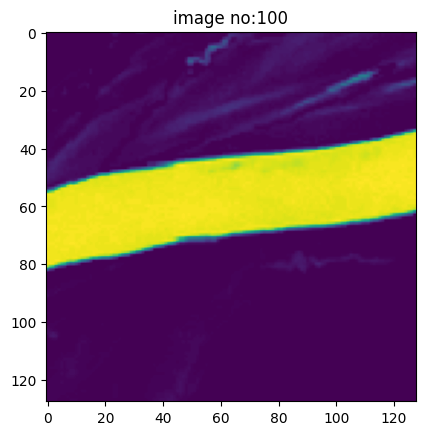

In [3]:
import rasterio as rio
#import folium
from skimage.io import imread
image = imread('/kaggle/input/watersegmentation2/data/images/100.tif')
print (image.shape)
plt.imshow(image[:,:,11],cmap=None)
plt.axes = False
plt.title("image no:100");

(128, 128, 12)


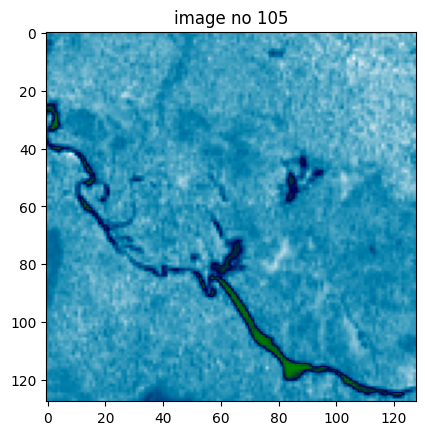

In [4]:
from skimage.io import imread
image = imread('/kaggle/input/watersegmentation2/data/images/105.tif')
print (image.shape)
plt.imshow(image[:,:,4], cmap = 'ocean') 
plt.axes = False
plt.title("image no 105");

In [5]:
# List and sort image and label files
images = sorted(os.listdir(image_path), key=lambda x: int(x.split(".")[0]))
labels = sorted(os.listdir(label_path), key=lambda x: int(x.split(".")[0]))

In [6]:
modified_labels = [label for label in labels if "_" not in label.split(".")[0]]
print(f"Number of images: {len(images)}")
print(f"Number of labels: {len(labels)}")
print(f"Number of Modified labels: {len(modified_labels)}")

Number of images: 306
Number of labels: 456
Number of Modified labels: 306


In [7]:
# Load images and labels
arr_images = [imread(f"{image_path}/{indx}.tif") for indx in range(306)]
arr_labels = [imread(f"{label_path}/{indx}.png") for indx in range(306)]

In [8]:
# Check image and label shapes
print(f"Image shape: {arr_images[5].shape}")
print(f"Label shape: {arr_labels[5].shape}")


Image shape: (128, 128, 12)
Label shape: (128, 128)


In [9]:

# Normalize images across all channels
normalized_arr = np.zeros_like(arr_images)
for i, img in enumerate(arr_images):
    for c in range(12):  # Assuming 12 channels
        min_val = np.min(img[:, :, c])
        max_val = np.max(img[:, :, c])
        if max_val - min_val != 0:  # Prevent division by zero
            normalized_arr[i][:, :, c] = (img[:, :, c] - min_val) / (max_val - min_val)

In [10]:

# Ensure the images and labels are numpy arrays
x_train = np.array(normalized_arr)
y_train = np.array(arr_labels)

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [13]:
# One-hot encode labels (for 3 classes)
from tensorflow.keras.utils import to_categorical

num_classes = 3
y_train = np.expand_dims(y_train, axis=-1)  # Add a channel dimension if necessary
y_train = to_categorical(y_train, num_classes=num_classes)

y_val = np.expand_dims(y_val, axis=-1)
y_val = to_categorical(y_val, num_classes=num_classes)

# Reshape labels to have 3 channels (one for each class)
y_train = y_train.reshape(-1, 128, 128, num_classes)
y_val = y_val.reshape(-1, 128, 128, num_classes)


In [14]:
# Select first 3 channels of the input images for the model (since the model expects 3-channel input)
x_train_rgb = x_train[..., :3]
x_val_rgb = x_val[..., :3]

In [15]:
# Data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=30)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train_rgb, y_train, batch_size=32)
val_generator = val_datagen.flow(x_val_rgb, y_val, batch_size=32)


In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
def deeplabv3_mobilenet(input_shape=(128, 128, 3), num_classes=3):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Encoder
    x = base_model.output
    x = Conv2D(256, (1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    
    # Atrous Spatial Pyramid Pooling (ASPP) Module
    x = Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Upsample to match input size
    x = UpSampling2D(size=(32, 32), interpolation='bilinear')(x)  # Adjust size based on downsampling
    
    # Output layer: num_classes channels (RGB)
    x = Conv2D(num_classes, (1, 1), padding='same',activation='softmax')(x)  # No activation here
    
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

In [18]:
model = deeplabv3_mobilenet(input_shape=(128, 128, 3), num_classes=3)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 4,361,027 (16.64 MB)

 Trainable params: 4,324,867 (16.50 MB)

 Non-trainable params: 36,160 (141.25 KB)

In [22]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726326074.833656     113 service.cc:145] XLA service 0x7f59440038e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726326074.833705     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726326102.888028     113 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_transpose_fusion_58', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1726326102.934471     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lif

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4127 - loss: 1.2380  

I0000 00:00:1726326131.882262     113 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_transpose_fusion', 4 bytes spill stores, 4 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - accuracy: 0.4248 - loss: 1.2164 - val_accuracy: 0.7064 - val_loss: 1.0403
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7106 - loss: 0.7280 - val_accuracy: 0.7067 - val_loss: 1.0201
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.7286 - loss: 0.6509 - val_accuracy: 0.7067 - val_loss: 1.0119
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.7270 - loss: 0.6171 - val_accuracy: 0.7067 - val_loss: 1.0086
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7362 - loss: 0.5967 - val_accuracy: 0.7067 - val_loss: 1.0037
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.7578 - loss: 0.5667 - val_accuracy: 0.7067 - val_loss: 1.0097
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.7377 - loss: 0.5896 - val_accuracy: 0.7067 - val_loss: 0.9932
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7208 - loss: 0.6044 - val_accuracy: 0.7067 - val_loss: 0.9785
Epoch

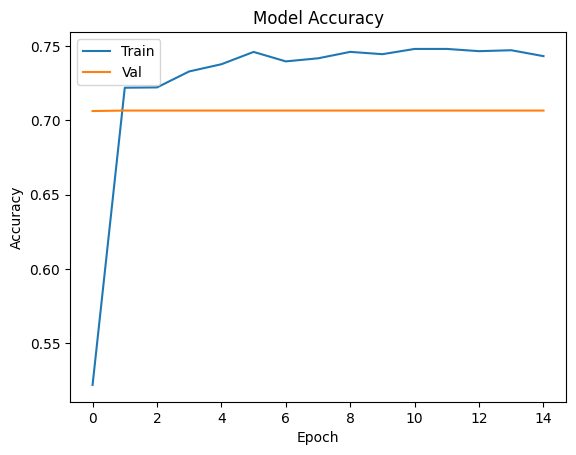

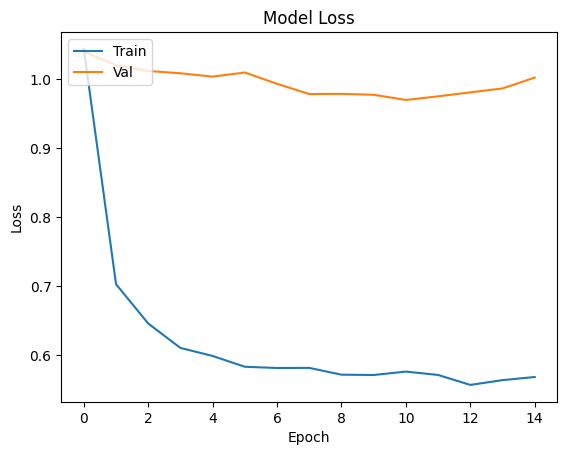

In [23]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
